In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nxcals.api.extraction.data.builders import ParameterDataQuery, DataQuery
from pyspark.sql.functions import col, expr, aggregate
from zoneinfo import ZoneInfo
from functools import reduce
from pyspark.sql import functions as F

import pyspark.pandas as ps

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = '1'

#from nxcals.spark_session_builder import get_or_create
#spark = get_or_create("MY_APP")

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [55]:
funds = DataQuery.builder(spark).byVariables() \
    .system('CMW') \
    .startTime('2025-05-10 16:00:00.000').endTime('2025-05-13 04:00:00.000') \
    .variable('CPS:NXCALS_FUNDAMENTAL') \
    .buildDataset()

funds.groupBy("USER").count().show()

+--------+-----+
|    USER|count|
+--------+-----+
|     MD7|  918|
|   EAST1| 9382|
|      AD| 1760|
|    ZERO|40789|
|   EAST3|16746|
|    LHC1| 1950|
|   EAST2| 6958|
| SFTPRO1|23545|
|     TOF|28172|
|     MD9| 4875|
|   EAST4|  111|
| LHCIND1|  469|
|     MD4|  137|
|    LHC4|  154|
|    LHC5|  154|
|LHCPILOT|  198|
|     MD1|  405|
| LHCIND3| 1126|
|     MD2|   82|
+--------+-----+



In [2]:
# helper method that filters df for only desired user by matching cyclestamps
def filter_user(df, user, start_time, end_time):
    
    funds = DataQuery.builder(spark).byVariables() \
        .system('CMW') \
        .startTime(start_time).endTime(end_time) \
        .variable('CPS:NXCALS_FUNDAMENTAL') \
        .buildDataset()
    
    cyclestamps = funds.filter(col("USER") == user).select("cyclestamp")
    
    df = df.join(cyclestamps,on="cyclestamp",how="inner")
    
    return df

# sends cyclestamps to corresponding datetimes
def format_datetime(data):
    data['cyclestamp'] = pd.to_datetime(data['cyclestamp'], utc=True)
    data.set_index(data['cyclestamp'].dt.tz_convert(ZoneInfo("Europe/Berlin")), inplace=True, drop=True)
    data.sort_index(inplace=True)
    return data

# get the df for 90% emittance
def get_90emitt(user, start_time, end_time):
    # import data
    df = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PS.RING.PROC.TOMO_BCW_OP_BURST_13/NxcalsLogging") \
        .timeWindow(start_time, end_time) \
        .build()
    
    # get correct user
    df = filter_user(df, user, start_time, end_time)
    
    # to pandas and convert to date
    data = df.select("cyclestamp","meanEmitt90Perc").toPandas()
    
    return data  


In [57]:
def get_plots(user, start_time, end_time):  
    
    # 90% EMITTANCE
    
    # get data and format dates
    data = get_90emitt(user, start_time, end_time)


    mu = data['meanEmitt90Perc'].mean()
    sigma = data['meanEmitt90Perc'].std()
    thresh = 4
    data['z_score'] = (data['meanEmitt90Perc'] - mu) / sigma
    cyclestamps_high = set(data.loc[data['z_score'] > thresh, 'cyclestamp'].tolist())
    cyclestamps_low = set(data.loc[data['z_score'] < -thresh, 'cyclestamp'].tolist())

    data = format_datetime(data)

    data.set_index('cyclestamp', inplace=True)
    
    # Apply moving average with a window of, say, 5
    data['smoothed_emittance'] = data['meanEmitt90Perc'].rolling(window=20, center=True).mean()

    # plot
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data['meanEmitt90Perc'], alpha=0.5, label='Original')
    plt.plot(data.index, data['smoothed_emittance'], color='red', label='Smoothed')
    plt.axhline((thresh*sigma+mu), linestyle = '--', label = 'High break', color='red')
    plt.axhline((-thresh*sigma+mu), linestyle = '--', label = 'Low break', color= 'green')
    plt.xlabel("Date")
    plt.ylabel("Mean 90% emittance [eVs]")
    #plt.ylim(1,1.8)
    plt.title(user + " 90% emittance")
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()

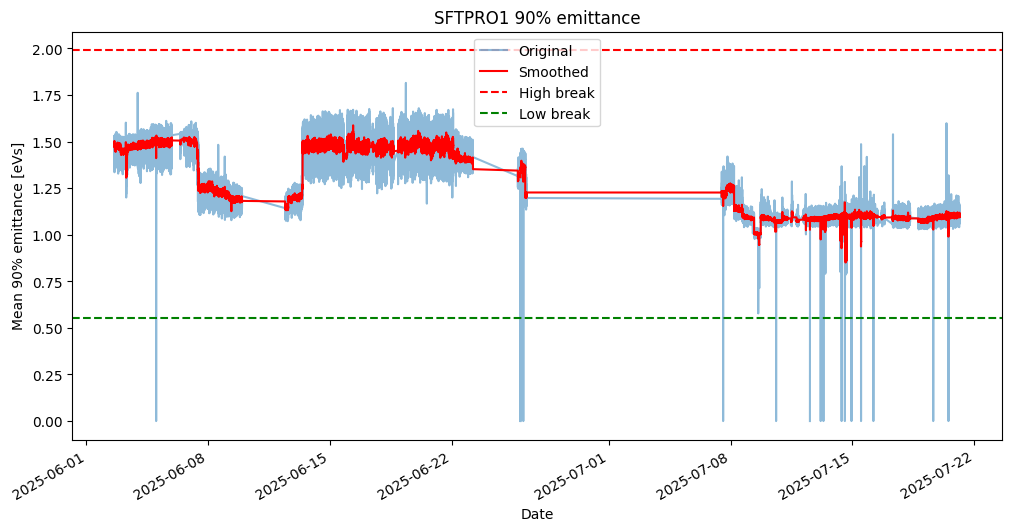

In [28]:
get_plots('SFTPRO1','2025-06-01 01:00:00.000', '2025-07-21 04:00:00.000')

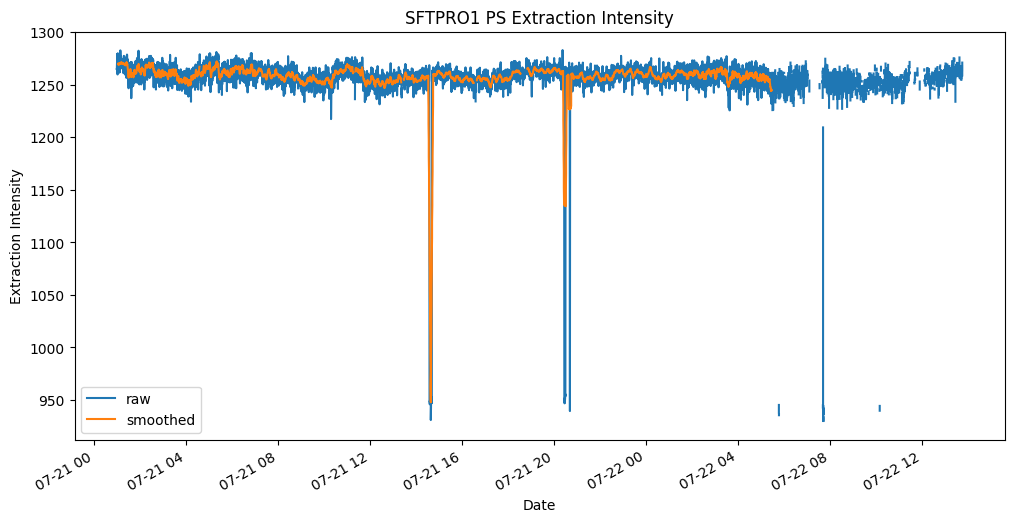

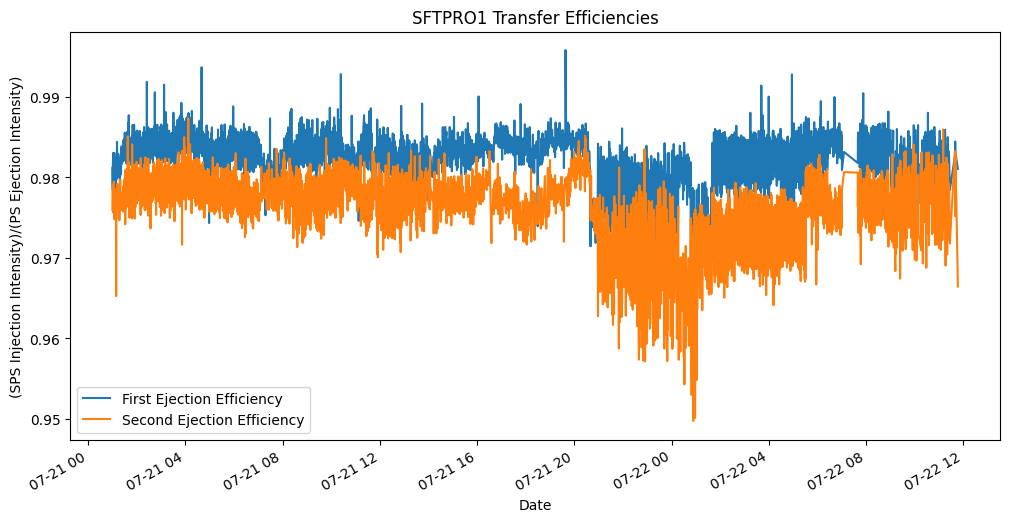

25/07/22 15:45:38 WARN ClientCnxn: An exception was thrown while closing send thread for session 0x3050ceaa5a97fe5.
EndOfStreamException: Unable to read additional data from server sessionid 0x3050ceaa5a97fe5, likely server has closed socket
	at org.apache.zookeeper.ClientCnxnSocketNIO.doIO(ClientCnxnSocketNIO.java:77)
	at org.apache.zookeeper.ClientCnxnSocketNIO.doTransport(ClientCnxnSocketNIO.java:350)
	at org.apache.zookeeper.ClientCnxn$SendThread.run(ClientCnxn.java:1290)


In [72]:


# intensity and efficiency

def plot_intensity_efficiency(user, start_time, end_time):

    # intensity
    
    ps_intensity = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PR.BCT/HotspotIntensity") \
        .timeWindow(start_time, end_time) \
        .build()

    ps_intensity = ps_intensity.select("cyclestamp", "dcBefEje1")

    ps_intensity = filter_user(ps_intensity, user, start_time, end_time)
    ps_intensity = ps_intensity.toPandas()
    ps_intensity.dropna(axis=0, how = "any")
    ps_intensity = format_datetime(ps_intensity)

    ps_intensity.set_index('cyclestamp', inplace=True)
    ps_intensity = ps_intensity.where(ps_intensity["dcBefEje1"]>20)

    ps_intensity['smoothed_intensity'] = ps_intensity['dcBefEje1'].rolling(window=20, center=True).mean()


    plt.figure(figsize=(12,6))
    plt.plot(ps_intensity.index, ps_intensity["dcBefEje1"], label = "raw")
    plt.plot(ps_intensity.index, ps_intensity['smoothed_intensity'], label = "smoothed")
    plt.xlabel("Date")
    plt.ylabel("Extraction Intensity")
    plt.gcf().autofmt_xdate()
    plt.title(user + " PS Extraction Intensity")
    plt.legend()
    plt.show()

    # efficiency
    
    sps_intensity = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("SPS.BCTDC24.51454/Acquisition") \
        .timeWindow(start_time, end_time) \
        .build()

    sps_intensity = sps_intensity.select("cyclestamp", "intensityInjected")

    # have to filter manually since SPS
    funds = DataQuery.builder(spark).byVariables() \
        .system('CMW') \
        .startTime(start_time).endTime(end_time) \
        .variable('SPS:NXCALS_FUNDAMENTAL') \
        .buildDataset()
    cyclestamps = funds.filter(col("USER") == user).select("cyclestamp")
    sps_intensity = sps_intensity.join(cyclestamps,on="cyclestamp",how="inner")


    sps_intensity = format_datetime(sps_intensity.toPandas())
    sps_intensity.set_index('cyclestamp', inplace=True)
    sps_intensity.dropna(axis=0, how = "any")

    i = 0
    j = 0
    dt = pd.Timedelta(seconds=1.2)
    effs = pd.DataFrame(columns=['cyclestamp','first_eff', 'second_eff'])
    
    while (i < len(ps_intensity)-1 and j < len(sps_intensity)):
        
        # get the timestamps we are pointing to
        ps1_stamp = ps_intensity.index[i]
        ps2_stamp = ps_intensity.index[i+1]
        sps_stamp = sps_intensity.index[j]

        # if PS stamps enclose the SPS stamp
        if ps1_stamp <= sps_stamp <= ps2_stamp:
            # if the PS stamps are 1.2 s apart
            if (ps2_stamp - ps1_stamp == dt):
                sps_array = np.array(sps_intensity.iloc[j]['intensityInjected']['elements'])
                # if SPS intensity is a too small, move on
                if (sps_array[0] < 500 or sps_array[1] < 500):
                    j +=1
                else:
                    ps1_val = ps_intensity.iloc[i]['dcBefEje1']
                    ps2_val = ps_intensity.iloc[i+1]['dcBefEje1']
                    first_eff = sps_array[0] / ps1_val
                    second_eff = sps_array[1] / ps2_val
                    
                    effs.loc[len(effs)] = [sps_stamp, first_eff, second_eff]
                    i += 1
                    j += 1
            else:
                i += 1
        elif sps_stamp < ps1_stamp:
            j += 1
        else:
            i += 1

    effs.set_index('cyclestamp', inplace=True)
    effs = effs.dropna(subset=['first_eff', 'second_eff'])
    effs = effs[effs.index.notna()]
    
    plt.figure(figsize=(12,6))
    plt.plot(effs.index, effs['first_eff'], label = "First Ejection Efficiency")
    plt.plot(effs.index, effs['second_eff'], label = "Second Ejection Efficiency")
    plt.xlabel("Date")
    plt.ylabel("(SPS Injection Intensity)/(PS Ejection Intensity)")
    plt.gcf().autofmt_xdate()
    plt.title(user + " Transfer Efficiencies")
    plt.legend()
    plt.show()



    
    

plot_intensity_efficiency('SFTPRO1','2025-07-21 01:00:00.000', '2025-07-22 15:00:00.000')

# for efficiency: in BCT, get PS SFT extraction 1, look 1.2 seconds later for PS SFT extraction 2
# then look in between these for an SPS SFT injection, and pull the intensity vector and match

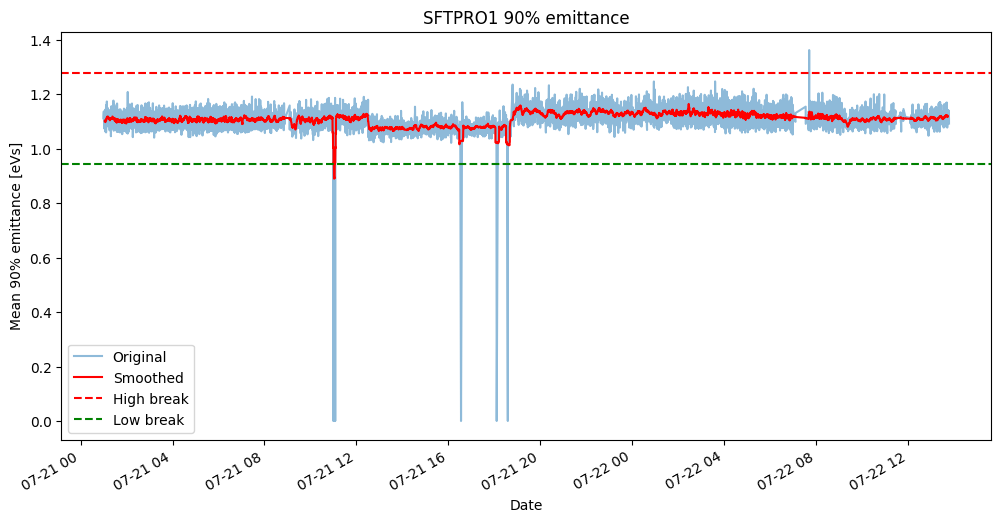

In [73]:
get_plots('SFTPRO1','2025-07-21 01:00:00.000', '2025-07-22 15:00:00.000')

In [3]:
df = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PS.RING.PROC.BUNCH_PROFILES_BCW_OP/BunchLengthData") \
    .timeWindow('2025-07-22 01:00:00.000', '2025-07-22 10:00:00.000') \
    .build()

# get correct user
df = filter_user(df, 'SFTPRO1','2025-07-22 01:00:00.000', '2025-07-22 10:00:00.000')

'''
df = df.withColumn("burstIdArray", df["burstId.elements"])
df = df.withColumn("bunchIntensityArray", df["bunchIntensityE10.elements"])
'''
df = df.select('cyclestamp', 'burstId', 'bunchIntensityE10')

df.printSchema()

25/07/25 09:19:37 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@749da354{/SQL,null,AVAILABLE,@Spark}
25/07/25 09:19:37 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@e04f0ec{/SQL/json,null,AVAILABLE,@Spark}
25/07/25 09:19:37 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@2dcdab99{/SQL/execution,null,AVAILABLE,@Spark}
25/07/25 09:19:37 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@6d93cdc4{/SQL/execution/json,null,AVAILABLE,@Spark}
25/07/25 09:19:37 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@3ca3ca16{/static/sql,null,AVAILABLE,@Spark}
root
 |-- cyclestamp: long (nullable = true)
 |-- burstId: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- dimensions: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |-- bunchIntensityE10: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element

In [4]:
from nxcals.api.common.utils.array_utils import ArrayUtils

h = ArrayUtils.reshape(df)

In [5]:
w = ps.DataFrame(h)

25/07/23 17:29:55 WARN CheckAllocator: More than one DefaultAllocationManager on classpath. Choosing first found


In [3]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import numpy as np

@udf(DoubleType())
def std_bunch_intensity_burst12(burstId, bunchIntensityE10):
    try:
        if not burstId or not bunchIntensityE10:
            return -1

        num_trace_points = len(burstId)
        num_bunches = 16

        # Step 1: find last index where burstId == 12
        last_idx = -1
        for i in reversed(range(num_trace_points)):
            if burstId[i] == 12:
                last_idx = i
                break

        if last_idx == -1:
            return -1  # burst 12 not found

        intensities = []
        for entry in bunchIntensityE10:
            if int(entry[1]) == last_idx:
                intensities.append(entry[0])
   
        if len(intensities) != num_bunches:
            return -1
  
        
        # Step 4: compute std dev
        return float(np.std(intensities))

    except Exception:
        return -1



25/07/26 17:38:38 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@6fafbdbc{/SQL,null,AVAILABLE,@Spark}
25/07/26 17:38:38 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@41cffd1a{/SQL/json,null,AVAILABLE,@Spark}
25/07/26 17:38:38 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@3e9f71bc{/SQL/execution,null,AVAILABLE,@Spark}
25/07/26 17:38:38 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@438fdb4b{/SQL/execution/json,null,AVAILABLE,@Spark}
25/07/26 17:38:38 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@777e4d7d{/static/sql,null,AVAILABLE,@Spark}


In [6]:
h = h.withColumn(
    "std_bunch_intensity_burst12",
    std_bunch_intensity_burst12("burstId", "bunchIntensityE10")
)


from pyspark.sql.functions import col

h2 = h.filter(col('std_bunch_intensity_burst12') != -1)



In [7]:
h2.count()

3512

In [8]:
h2 = h2.select('cyclestamp',"std_bunch_intensity_burst12")
h2.printSchema()

root
 |-- cyclestamp: long (nullable = true)
 |-- std_bunch_intensity_burst12: double (nullable = true)



In [9]:
h2.describe().show()

+-------+--------------------+---------------------------+
|summary|          cyclestamp|std_bunch_intensity_burst12|
+-------+--------------------+---------------------------+
|  count|                3512|                       3512|
|   mean|1.753161224991002...|          5.785156352430736|
| stddev|8.526644552059837E12|        0.25296285628310994|
|    min| 1753146004300000000|          4.843368573385547|
|    max| 1753178391100000000|         10.597471062126328|
+-------+--------------------+---------------------------+



In [10]:
data = h2.collect()
x = [row['cyclestamp'] for row in data]
y = [row['std_bunch_intensity_burst12'] for row in data]


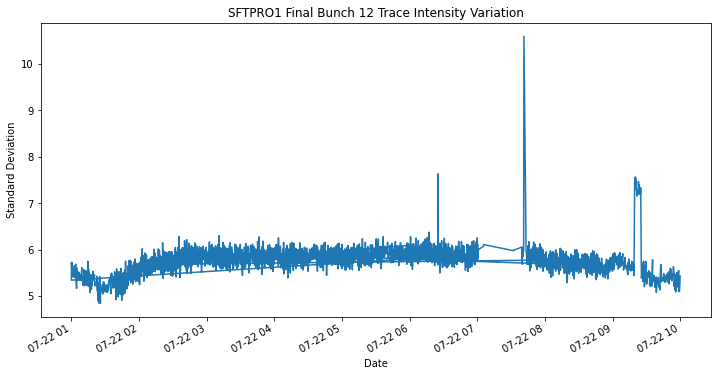

In [15]:
datetimes = pd.to_datetime(x, unit='ns')

plt.figure(figsize=(12,6))
plt.plot(datetimes, y)
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.gcf().autofmt_xdate()
plt.title("SFTPRO1 Final Bunch 12 Trace Intensity Variation")
plt.show()


In [7]:
from nxcals.api.common.utils.array_utils import ArrayUtils
from pyspark.sql.functions import col


def plot_intensity_var(user, start_time, end_time):
    df = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PS.RING.PROC.BUNCH_PROFILES_BCW_OP/BunchLengthData") \
        .timeWindow(start_time, end_time) \
        .build()
    
    df = df.select('cyclestamp', 'burstId', 'bunchIntensityE10')
    
    # get correct user
    df = filter_user(df, user, start_time, end_time)
    
    h = ArrayUtils.reshape(df)
    
    h = h.withColumn("std_bunch_intensity_burst12", std_bunch_intensity_burst12("burstId", "bunchIntensityE10"))

    h2 = h.select('cyclestamp',"std_bunch_intensity_burst12")
    
    h2 = h.filter(col('std_bunch_intensity_burst12') != -1)
    
    data = h2.collect()
    
    
    x = [row['cyclestamp'] for row in data]
    y = [row['std_bunch_intensity_burst12'] for row in data]
    
    datetimes = pd.to_datetime(x, unit='ns')

    plt.figure(figsize=(12,6))
    plt.plot(datetimes, y)
    plt.xlabel("Date")
    plt.ylabel("Standard Deviation")
    plt.gcf().autofmt_xdate()
    plt.title(user + " Bunch 12 Final Trace Intensity Variation")
    plt.show()



    

In [8]:
plot_intensity_var('SFTPRO1','2025-07-21 01:00:00.000', '2025-07-22 15:00:00.000')

25/07/26 17:46:19 ERROR TaskSetManager: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
25/07/26 17:46:19 WARN TaskSetManager: Lost task 331.0 in stage 9.0 (TID 136) (ithdp-nxcals8005.cern.ch executor 7): TaskKilled (Tasks result size has exceeded maxResultSize)
25/07/26 17:46:19 WARN TaskSetManager: Lost task 435.0 in stage 9.0 (TID 175) (ithdp-nxcals6005.cern.ch executor 9): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
25/07/26 17:46:19 WARN TaskSetManager: Lost task 337.0 in stage 9.0 (TID 160) (ithdp-nxcals8005.cern.ch executor 10): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
25/07/26 17:46:19 WARN TaskSetManager: Lost task 333.0 in stage 9.0 (TID 147) (i

Py4JJavaError: An error occurred while calling o244.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:418)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


25/07/26 17:46:20 WARN TaskSetManager: Lost task 459.0 in stage 9.0 (TID 167) (ithdp-nxcals7006.cern.ch executor 1): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
25/07/26 17:46:20 WARN TaskSetManager: Lost task 462.0 in stage 9.0 (TID 171) (ithdp-nxcals7006.cern.ch executor 1): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
25/07/26 17:46:20 WARN TaskSetManager: Lost task 473.0 in stage 9.0 (TID 191) (ithdp-nxcals7006.cern.ch executor 2): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
25/07/26 17:46:21 WARN TaskSetManager: Lost task 463.0 in stage 9.0 (TID 172) (ithdp-nxcals7006.cern.ch executor 3)

25/07/26 17:46:25 WARN TaskSetManager: Lost task 417.0 in stage 9.0 (TID 107) (ithdp-nxcals6005.cern.ch executor 6): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
25/07/26 17:46:25 WARN TaskSetManager: Lost task 434.0 in stage 9.0 (TID 161) (ithdp-nxcals6005.cern.ch executor 6): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
25/07/26 17:46:25 WARN TaskSetManager: Lost task 426.0 in stage 9.0 (TID 127) (ithdp-nxcals6005.cern.ch executor 6): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 137 tasks (1035.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
25/07/26 17:46:25 WARN TaskSetManager: Lost task 439.0 in stage 9.0 (TID 185) (ithdp-nxcals6005.cern.ch executor 6)